In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import desc
import datetime as dt
import matplotlib.patches as mpatches

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
####Explore tables with Inspector######
# Create the inspector and connect it to the engine
inspector = inspect(engine)

#inspector.get_table_names()

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [13]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [ ]:
###Data date range###
# 1/1/2010 - 8/23/2017

C:\Users\Chell\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


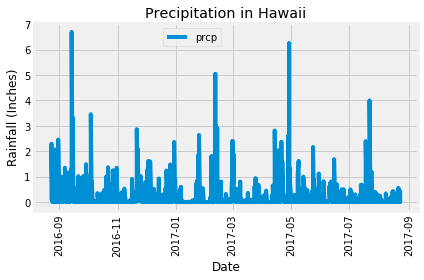

<Figure size 432x288 with 0 Axes>

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in recent_date:
    most_recent_date = date.date

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date 1 year ago from today
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recent_prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(recent_prcp_data).dropna()

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.5, 1.00))

# Rotate the xticks for the dates
plt.xticks(rotation='90')

plt.tight_layout()
plt.show()
#fig = plt.figure()
plt.savefig("Precipitation.png")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.prcp.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [17]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                                  group_by(Measurement.station).\
                                  order_by(desc('count')).all(),columns=["Station","No. of Measurements"])
station

,Station,No. of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(desc('count')).limit(1)[0][0]
                                    

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

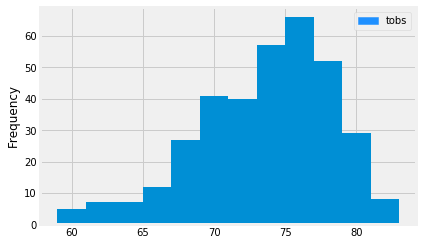

<Figure size 432x288 with 0 Axes>

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]



plt.hist(x, bins=12)
plt.ylabel('Frequency')
tobs_patch = mpatches.Patch(color='dodgerblue', label='tobs')
plt.legend(handles=[tobs_patch])
plt.show()
plt.savefig("Station-Histogram.png")

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-07-01', '2017-07-10')
temps

[(69.0, 78.15254237288136, 87.0)]

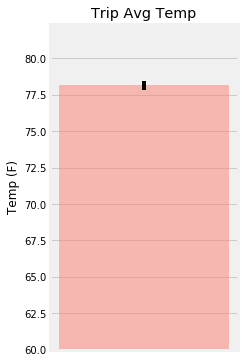

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by(desc('rainfall')).all()

rainfall('2017-07-01', '2017-07-10')


[('USC00516128', 0.1, 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.08, 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 0.06, 21.4234, -157.8015, 14.6),
 ('USC00519397', 0.02, 21.2716, -157.8168, 3.0),
 ('USC00514830', None, 21.5213, -157.8374, 7.0),
 ('USC00517948', None, 21.3934, -157.9751, 11.9),
 ('USC00519523', None, 21.33556, -157.71139, 19.5)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
